In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


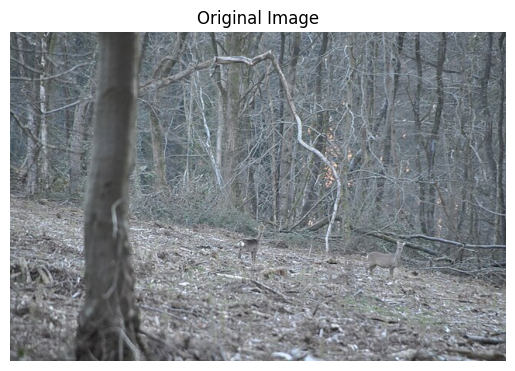

In [50]:
# Load image
img_path = "./test_images/small.jpg"
img = Image.open(img_path).convert("RGB")
img_np = np.asarray(img) / 255.0  # normalize to [0, 1]

# Display
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")
plt.show()


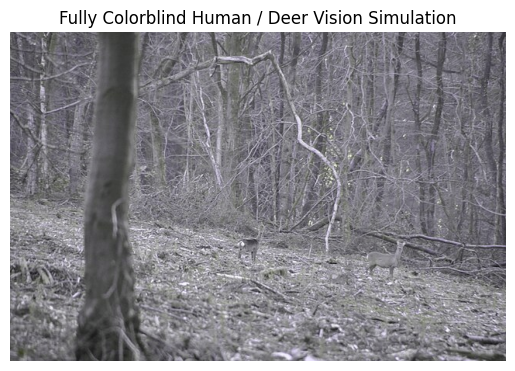

Saved transformed image to ./test_images/fall_deer_sim.png


In [51]:
"""
An example of Full Colorblindness in humans as a baseline, using resources from
https://ixora.io/projects/colorblindness/color-blindness-simulation-research/
and 
https://www.inf.ufrgs.br/~oliveira/pubs_files/CVD_Simulation/CVD_Simulation.html
"""

# sRGB to Linear RGB conversion

def srgb_to_linear(c):
    a = 0.055
    return np.where(c <= 0.04045, c / 12.92, ((c + a) / (1 + a)) ** 2.4)

linear_rgb = srgb_to_linear(img_np)

# RGB to LMS (Hunt–Pointer–Estevez)
T_RGB2LMS = np.array([
    [0.31399022, 0.63951294, 0.04649755],
    [0.15537241, 0.75789446, 0.08670142],
    [0.01775239, 0.10944209, 0.87256922]
])

# LMS to RGB (inverse)
T_LMS2RGB = np.linalg.inv(T_RGB2LMS)

lms = np.tensordot(linear_rgb, T_RGB2LMS.T, axes=1)

# Protanopia-inspired matrix (remove L-cone influence)
P_deer = np.array([
    [0, 1.0, 0],    # L becomes function of M only
    [0, 1.0, 0],    # M unchanged
    [0, 0, 1.0]     # S unchanged
])

lms_deer = np.tensordot(lms, P_deer.T, axes=1)

linear_rgb_deer = np.tensordot(lms_deer, T_LMS2RGB.T, axes=1)
linear_rgb_deer = np.clip(linear_rgb_deer, 0, 1)

def linear_to_srgb(c):
    a = 0.055
    return np.where(c <= 0.0031308, c * 12.92, (1 + a) * np.power(c, 1 / 2.4) - a)

srgb_deer = linear_to_srgb(linear_rgb_deer)
srgb_deer_img = (np.clip(srgb_deer, 0, 1) * 255).astype(np.uint8)

plt.imshow(srgb_deer_img)
plt.title("Fully Colorblind Human / Deer Vision Simulation")
plt.axis("off")
plt.show()

out_path = "./test_images/fall_deer_sim.png"
Image.fromarray(srgb_deer_img).save(out_path)
print(f"Saved transformed image to {out_path}")



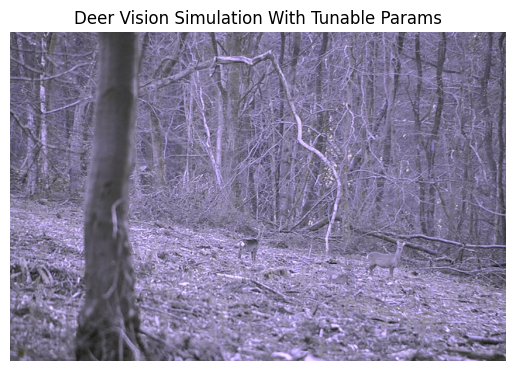

In [52]:
# Tunable parameters
params = {
    "dichromacy_strength": 1,   # 0 = human, 1 = full deer
    "ms_mixing_L": 1.05,           # Contribution from M to synthetic L
    "ss_mixing_L": -0.05,           # Contribution from S to synthetic L
    "blue_boost": 1.7,            # How much brighter S (blue/UV) gets
    "blue_gamma": 1.15             # <1 boosts shadows, >1 boosts highlights
}
def apply_deer_LMS_projection(lms, params):
    strength = params["dichromacy_strength"]

    # Original human LMS
    L = lms[..., 0]
    M = lms[..., 1]
    S = lms[..., 2]
    
    # Construct synthetic L from M & S
    L_synth = (params["ms_mixing_L"] * M +
               params["ss_mixing_L"] * S)
    
    # Blend between human and deer
    L_new = (1 - strength) * L + strength * L_synth
    
    return np.stack([L_new, M, S], axis=-1)

def apply_blue_uv_boost(lms, params):
    S = lms[..., 2]
    boost = params["blue_boost"]
    gamma = params["blue_gamma"]

    # Gamma curve to control how shadows/highlights behave
    S_boosted = (S ** gamma) * boost

    lms[..., 2] = S_boosted
    return np.clip(lms, 0, None)

lms_mod = apply_deer_LMS_projection(lms, params)
lms_mod = apply_blue_uv_boost(lms_mod, params)
linear_rgb_deer = np.tensordot(lms_mod, T_LMS2RGB.T, axes=1)
linear_rgb_deer = np.clip(linear_rgb_deer, 0, 1)
srgb_deer = linear_to_srgb(linear_rgb_deer)
plt.imshow(srgb_deer)
plt.title("Deer Vision Simulation With Tunable Params")
plt.axis("off")
plt.show()


In [53]:
import torch
import cv2
import numpy as np

def load_midas():
    model_type = "DPT_Hybrid"
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device)
    midas.eval()

    return midas, transform, device

midas, midas_transform, device = load_midas()


/home/mastermind63/miniconda3/envs/deergoggles/lib/python3.11/site-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /home/mastermind63/.cache/torch/hub/master.zip


/home/mastermind63/miniconda3/envs/deergoggles/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/mastermind63/miniconda3/envs/deergoggles/lib/python3.11/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_hybrid_384.pt" to /home/mastermind63/.cache/torch/hub/checkpoints/dpt_hybrid_384.pt


100%|██████████| 470M/470M [00:13<00:00, 36.3MB/s] 
Using cache found in /home/mastermind63/.cache/torch/hub/intel-isl_MiDaS_master


In [59]:
def estimate_depth(img_np):
    input_batch = midas_transform(img_np).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

    depth = prediction.squeeze().cpu().numpy()
    depth = cv2.resize(depth, (img_np.shape[1], img_np.shape[0]))
    depth_norm = (depth - depth.min()) / (depth.max() - depth.min())

    return depth_norm


In [55]:
def blur_by_depth(img, depth, max_blur=10):
    img_blurred = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            blur_amount = int(depth[i, j] * max_blur)
            if blur_amount > 0:
                k = blur_amount * 2 + 1
                img_blurred[i, j] = cv2.GaussianBlur(img, (k, k), 0)[i, j]
            else:
                img_blurred[i, j] = img[i, j]

    return img_blurred


In [56]:
def process_deer_vision(img_path, params):
    # --- 1. Load image ---
    img = Image.open(img_path).convert("RGB")
    img_np = np.asarray(img) / 255.0

    # --- 2. Linearize ---
    lin = srgb_to_linear(img_np)

    # --- 3. RGB → LMS ---
    lms = np.tensordot(lin, T_RGB2LMS.T, axes=1)

    # --- 4. Deer LMS projection ---
    lms_mod = apply_deer_LMS_projection(lms, params)

    # --- 5. Blue/UV enhancement ---
    lms_mod = apply_blue_uv_boost(lms_mod, params)

    # --- 6. LMS → RGB ---
    lin_deer = np.tensordot(lms_mod, T_LMS2RGB.T, axes=1)
    lin_deer = np.clip(lin_deer, 0, 1)

    # --- 7. Convert to sRGB ---
    srgb = linear_to_srgb(lin_deer)
    srgb_uint8 = (np.clip(srgb, 0, 1) * 255).astype(np.uint8)

    # --- 8. Estimate depth ---
    depth = estimate_depth(srgb_uint8)

    # --- 9. Blur background proportionally ---
    final_img = blur_by_depth(srgb_uint8, depth, max_blur=params["max_blur"])

    return srgb_uint8, depth, final_img


In [62]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

def interactive_deer(img_path):

    @interact(
        dichromacy_strength=widgets.FloatSlider(value=1.0, min=0, max=1, step=0.05),
        ms_mixing_L=widgets.FloatSlider(value=1.0, min=0, max=2, step=0.05),
        ss_mixing_L=widgets.FloatSlider(value=0.0, min=0, max=2, step=0.05),
        blue_boost=widgets.FloatSlider(value=1.4, min=0.5, max=3, step=0.1),
        blue_gamma=widgets.FloatSlider(value=0.8, min=0.2, max=2, step=0.1),
        max_blur=widgets.IntSlider(value=5, min=0, max=20, step=1)
    )
    def update(dichromacy_strength, ms_mixing_L, ss_mixing_L,
               blue_boost, blue_gamma, max_blur):

        params = {
            "dichromacy_strength": dichromacy_strength,
            "ms_mixing_L": ms_mixing_L,
            "ss_mixing_L": ss_mixing_L,
            "blue_boost": blue_boost,
            "blue_gamma": blue_gamma,
            "max_blur": max_blur
        }

        sim_img, depth, final_img = process_deer_vision(img_path, params)

        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1); plt.imshow(sim_img); plt.title("Color Shift"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(depth, cmap="inferno"); plt.title("Depth Map"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(final_img); plt.title("Final Deer Simulation"); plt.axis("off")
        plt.show()



In [63]:
import glob

def batch_process_images(params, input_dir="./test_images/"):
    images = sorted(glob.glob(os.path.join(input_dir, "*.jpg")) +
                    glob.glob(os.path.join(input_dir, "*.png")))

    results = []
    for path in images:
        _, _, final_img = process_deer_vision(path, params)
        results.append((path, final_img))

    # Display side-by-side
    cols = 3
    rows = int(np.ceil(len(results)/cols))

    plt.figure(figsize=(15, 5*rows))
    for i, (path, img) in enumerate(results):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(path))
        plt.axis("off")
    plt.show()


In [76]:
interactive_deer("./test_images/fall.jpg")


interactive(children=(FloatSlider(value=1.0, description='dichromacy_strength', max=1.0, step=0.05), FloatSlid…

Using cache found in /home/mastermind63/.cache/torch/hub/intel-isl_MiDaS_master
/home/mastermind63/miniconda3/envs/deergoggles/lib/python3.11/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /home/mastermind63/.cache/torch/hub/intel-isl_MiDaS_master


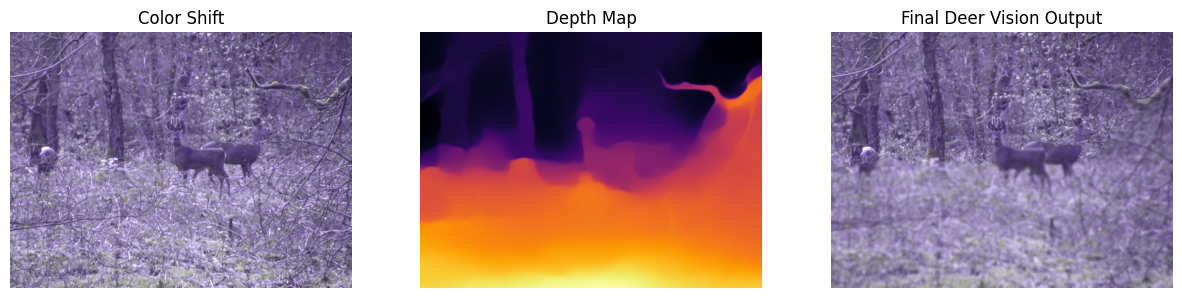

In [77]:
# ============================
# Full Deer Vision Pipeline
# One-Cell Working Version
# ============================

import numpy as np
import cv2
import torch
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------------------
#  Utility Functions: Linear <-> sRGB
# ---------------------------------------
def srgb_to_linear(c):
    a = 0.055
    return np.where(c <= 0.04045, c / 12.92,
                    ((c + a) / (1 + a)) ** 2.4)

def linear_to_srgb(c):
    a = 0.055
    return np.where(c <= 0.0031308,
                    c * 12.92,
                    (1 + a) * (c ** (1/2.4)) - a)


# ---------------------------------------
#  Color Transform Matrices
# ---------------------------------------
T_RGB2LMS = np.array([
    [0.31399022, 0.63951294, 0.04649755],
    [0.15537241, 0.75789446, 0.08670142],
    [0.01775239, 0.10944209, 0.87256922]
])
T_LMS2RGB = np.linalg.inv(T_RGB2LMS)


# ---------------------------------------
#  LMS Transform Functions
# ---------------------------------------
def apply_deer_LMS_projection(lms, params):
    L = lms[..., 0]
    M = lms[..., 1]
    S = lms[..., 2]

    # Synthetic L = combination of M and S
    L_synth = (params["ms_mixing_L"] * M +
               params["ss_mixing_L"] * S)

    # Blend between human & deer/P-anopia
    L_new = (1 - params["dichromacy_strength"]) * L + \
             params["dichromacy_strength"] * L_synth

    return np.stack([L_new, M, S], axis=-1)

def apply_blue_uv_boost(lms, params):
    S = lms[..., 2]
    S_boosted = (S ** params["blue_gamma"]) * params["blue_boost"]
    lms[..., 2] = S_boosted
    return np.clip(lms, 0, None)


# ---------------------------------------
#  Depth Estimation (MiDaS DPT-Hybrid)
# ---------------------------------------
def load_midas():
    model_type = "DPT_Hybrid"
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    transform = midas_transforms.dpt_transform

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device).eval()
    return midas, transform, device

midas, midas_transform, device = load_midas()

def estimate_depth(img_np):
    input_batch = midas_transform(img_np).to(device)
    with torch.no_grad():
        pred = midas(input_batch)
    depth = pred.squeeze().cpu().numpy()

    # Resize to original resolution
    H, W = img_np.shape[:2]
    depth = cv2.resize(depth, (W, H))
    depth_norm = (depth - depth.min()) / (depth.max() - depth.min())
    return depth_norm


# ---------------------------------------
#  Fast Depth-Masked Background Blur
# ---------------------------------------
def blur_by_depth_mask(img, depth, threshold=0.4, max_blur=11):
    if max_blur % 2 == 0:
        max_blur += 1

    blurred = cv2.GaussianBlur(img, (max_blur, max_blur), 0)

    mask = (depth > threshold).astype(np.float32)
    mask = cv2.GaussianBlur(mask, (21, 21), 0)[..., None]

    out = img * (1 - mask) + blurred * mask
    return out.astype(np.uint8)


# ---------------------------------------
#  Main Pipeline
# ---------------------------------------
def process_deer_vision(img_path, params):
    # Load image
    img = Image.open(img_path).convert("RGB")
    img_np = np.asarray(img) / 255.0

    # Convert to linear
    lin = srgb_to_linear(img_np)

    # RGB → LMS
    lms = np.tensordot(lin, T_RGB2LMS.T, axes=1)

    # Deer LMS projection
    lms_mod = apply_deer_LMS_projection(lms, params)

    # Blue/UV enhancement
    lms_mod = apply_blue_uv_boost(lms_mod, params)

    # LMS → RGB (linear)
    lin_deer = np.tensordot(lms_mod, T_LMS2RGB.T, axes=1)
    lin_deer = np.clip(lin_deer, 0, 1)

    # Encode sRGB
    srgb = linear_to_srgb(lin_deer)
    srgb_uint8 = (np.clip(srgb, 0, 1) * 255).astype(np.uint8)

    # Depth map
    depth = estimate_depth(srgb_uint8)

    # Apply selective blur
    final_img = blur_by_depth_mask(
        srgb_uint8,
        depth,
        threshold=params["blur_threshold"],
        max_blur=params["max_blur"]
    )

    return srgb_uint8, depth, final_img


# ---------------------------------------
#  Run the Pipeline on fall.jpg
# ---------------------------------------
params = {
    "dichromacy_strength": 1.0,
    "ms_mixing_L": 1.0,
    "ss_mixing_L": 0.0,
    "blue_boost": 1.4,
    "blue_gamma": 0.8,
    "max_blur": 11,
    "blur_threshold": 0.35,
}

sim_img, depth, final_img = process_deer_vision("./test_images/fall.jpg", params)

# Display results
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(sim_img); plt.axis("off"); plt.title("Color Shift")
plt.subplot(1,3,2); plt.imshow(depth, cmap="inferno"); plt.axis("off"); plt.title("Depth Map")
plt.subplot(1,3,3); plt.imshow(final_img); plt.axis("off"); plt.title("Final Deer Vision Output")
plt.show()


Using cache found in /home/mastermind63/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/mastermind63/.cache/torch/hub/intel-isl_MiDaS_master


Processing deer vision simulation...
Estimating depth from original image...
Applying deer color vision simulation...
Applying progressive nearsighted blur...


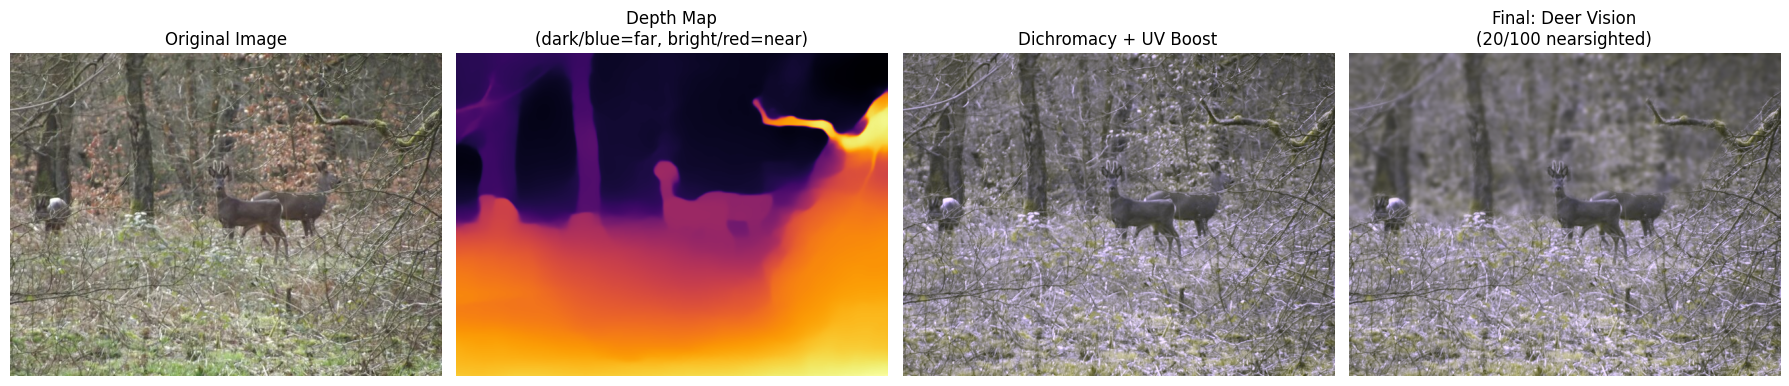

Done! Background should now be blurred (far objects)


In [109]:
# ============================
# Full Deer Vision Pipeline
# Fixed Version
# ============================

import numpy as np
import cv2
import torch
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------------------
#  Utility Functions: Linear <-> sRGB
# ---------------------------------------
def srgb_to_linear(c):
    a = 0.055
    return np.where(c <= 0.04045, c / 12.92,
                    ((c + a) / (1 + a)) ** 2.4)

def linear_to_srgb(c):
    a = 0.055
    return np.where(c <= 0.0031308,
                    c * 12.92,
                    (1 + a) * (c ** (1/2.4)) - a)


# ---------------------------------------
#  Color Transform Matrices
# ---------------------------------------
T_RGB2LMS = np.array([
    [0.31399022, 0.63951294, 0.04649755],
    [0.15537241, 0.75789446, 0.08670142],
    [0.01775239, 0.10944209, 0.87256922]
])
T_LMS2RGB = np.linalg.inv(T_RGB2LMS)


# ---------------------------------------
#  LMS Transform Functions
# ---------------------------------------
def apply_deer_LMS_projection(lms, params):
    L = lms[..., 0]
    M = lms[..., 1]
    S = lms[..., 2]

    # Synthetic L = combination of M and S
    L_synth = (params["ms_mixing_L"] * M +
               params["ss_mixing_L"] * S)

    # Blend between human & deer dichromacy
    L_new = (1 - params["dichromacy_strength"]) * L + \
             params["dichromacy_strength"] * L_synth

    return np.stack([L_new, M, S], axis=-1)

def apply_blue_uv_boost(lms, params):
    S = lms[..., 2]
    S_boosted = (S ** params["blue_gamma"]) * params["blue_boost"]
    lms[..., 2] = S_boosted
    return np.clip(lms, 0, None)


# ---------------------------------------
#  Depth Estimation (MiDaS DPT-Hybrid)
# ---------------------------------------
def load_midas():
    model_type = "DPT_Hybrid"
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    transform = midas_transforms.dpt_transform

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device).eval()
    return midas, transform, device

midas, midas_transform, device = load_midas()

def estimate_depth(img_np):
    """
    Estimate depth from original RGB image (before color shifting).
    Returns normalized depth map where 0=close, 1=far.
    """
    input_batch = midas_transform(img_np).to(device)
    with torch.no_grad():
        pred = midas(input_batch)
    depth = pred.squeeze().cpu().numpy()

    # Resize to original resolution
    H, W = img_np.shape[:2]
    depth = cv2.resize(depth, (W, H))
    
    # Normalize: higher values = farther away
    depth_norm = (depth - depth.min()) / (depth.max() - depth.min())
    return depth_norm


# ---------------------------------------
#  Progressive Depth-Based Blur
# ---------------------------------------
def blur_by_depth_progressive(img, depth, near_threshold=0.5, far_threshold=0.3, max_blur=21):
    """
    Apply progressive blur based on depth - smoothly increases with distance.
    Deer have 20/100 vision - they can't see far objects clearly.
    
    Note: MiDaS outputs inverse depth where LOWER values = farther away
    
    Parameters:
    - near_threshold: depth above this stays sharp (0.5 = top 50% closest objects)
    - far_threshold: depth below this gets max blur (0.3 = bottom 30% farthest objects)
    - max_blur: maximum blur kernel size for distant objects
    """
    if max_blur % 2 == 0:
        max_blur += 1
    
    # Create multiple blur levels for smooth transition
    blur_levels = []
    kernel_sizes = [1, 5, 9, 13, 17, max_blur]  # Progressive blur strengths
    
    for kernel_size in kernel_sizes:
        if kernel_size == 1:
            blur_levels.append(img)
        else:
            blur_levels.append(cv2.GaussianBlur(img, (kernel_size, kernel_size), 0))
    
    # Create smooth blur strength map
    # Invert depth so far = 1.0, near = 0.0
    inverted_depth = 1.0 - depth
    
    # Apply smooth transition between thresholds
    blur_strength = np.zeros_like(inverted_depth)
    
    # Objects closer than near_threshold: no blur
    blur_strength[inverted_depth < (1 - near_threshold)] = 0.0
    
    # Objects farther than far_threshold: max blur
    blur_strength[inverted_depth > (1 - far_threshold)] = 1.0
    
    # Objects in between: smooth gradient
    transition_mask = (inverted_depth >= (1 - near_threshold)) & (inverted_depth <= (1 - far_threshold))
    if transition_mask.any():
        transition_range = (1 - far_threshold) - (1 - near_threshold)
        blur_strength[transition_mask] = (inverted_depth[transition_mask] - (1 - near_threshold)) / transition_range
    
    # Smooth the blur strength map for natural transitions
    blur_strength = cv2.GaussianBlur(blur_strength, (31, 31), 0)
    
    # Apply progressive blur based on strength
    result = img.astype(np.float32)
    blur_strength_3d = blur_strength[..., None]
    
    # Blend between sharp and maximally blurred based on blur strength
    sharp = blur_levels[0].astype(np.float32)
    max_blurred = blur_levels[-1].astype(np.float32)
    
    result = sharp * (1 - blur_strength_3d) + max_blurred * blur_strength_3d
    
    return result.astype(np.uint8)


# ---------------------------------------
#  Main Pipeline (FIXED ORDER)
# ---------------------------------------
def process_deer_vision(img_path, params):
    # Load image
    img = Image.open(img_path).convert("RGB")
    img_np = np.asarray(img) / 255.0
    img_uint8 = (img_np * 255).astype(np.uint8)
    
    # STEP 1: Estimate depth BEFORE color transformation
    # This gives better depth estimation from natural RGB colors
    print("Estimating depth from original image...")
    depth = estimate_depth(img_uint8)
    
    # STEP 2: Apply color transformations
    print("Applying deer color vision simulation...")
    
    # Convert to linear
    lin = srgb_to_linear(img_np)

    # RGB → LMS
    lms = np.tensordot(lin, T_RGB2LMS.T, axes=1)

    # Deer LMS projection (dichromacy simulation)
    lms_mod = apply_deer_LMS_projection(lms, params)

    # Blue/UV enhancement (deer lack UV filter)
    lms_mod = apply_blue_uv_boost(lms_mod, params)

    # LMS → RGB (linear)
    lin_deer = np.tensordot(lms_mod, T_LMS2RGB.T, axes=1)
    lin_deer = np.clip(lin_deer, 0, 1)

    # Encode sRGB
    srgb = linear_to_srgb(lin_deer)
    srgb_uint8 = (np.clip(srgb, 0, 1) * 255).astype(np.uint8)

    # STEP 3: Apply progressive blur to background (20/100 vision)
    print("Applying progressive nearsighted blur...")
    final_img = blur_by_depth_progressive(
        srgb_uint8,
        depth,
        near_threshold=params["near_threshold"],
        far_threshold=params["far_threshold"],
        max_blur=params["max_blur"]
    )

    return srgb_uint8, depth, final_img


# ---------------------------------------
#  Run the Pipeline on fall.jpg
# ---------------------------------------
params = {
    "dichromacy_strength": 1.0,      # Full dichromacy (no human L-cone)
    "ms_mixing_L": 1.05,              # Synthetic L mainly from M-cone
    "ss_mixing_L": -0.05,              # Minimal S contribution to L
    "blue_boost": 1.7,               # UV sensitivity enhancement
    "blue_gamma": 1.15,               # Enhance blue/UV spectrum
    "max_blur": 14,                  # Maximum blur kernel for farthest objects
    "near_threshold": 0.4,           # Objects with depth > this stay sharp
    "far_threshold": 0.18,            # Objects with depth < this get max blur
}

img_path = "./test_images/fall.jpg"

print("Processing deer vision simulation...")
sim_img, depth, final_img = process_deer_vision(img_path, params)

# Display results
plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.imshow(Image.open(img_path))
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(depth, cmap="inferno")
plt.axis("off")
plt.title("Depth Map\n(dark/blue=far, bright/red=near)")

plt.subplot(1, 4, 3)
plt.imshow(sim_img)
plt.axis("off")
plt.title("Dichromacy + UV Boost")

plt.subplot(1, 4, 4)
plt.imshow(final_img)
plt.axis("off")
plt.title("Final: Deer Vision\n(20/100 nearsighted)")

plt.tight_layout()
plt.show()

print("Done! Background should now be blurred (far objects)")